Experiement Sampling

In [4]:
import pandas as pd
import numpy as np
import faker

import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.pyplot as plt
import math

import researchpy as rp

Fake case: 

Every customer service agent has a customer rating. To reduce customer complaints and improve rating, the company plans to roll out a X hour training. Before scaling up the program, the company would like to run an experiement to see whether the training helps reduce customer complaints. 

Step 1 Create a dummy sample data set

In [98]:
fake = faker.Faker()

# function to create a dataframe with fake values for our workers
def create_agents(num):
    
    state = [fake.state() for x in range(10)]

    agents = [{'Agent ID': x + 1000,
                  'Agent Name': fake.name(), 
                #   'Agent Tenure': int(np.random.uniform(0, 1000, 1)), 
                #   'State': np.random.choice(state),
                  'Compliant Rate': float(np.random.uniform(0,0.5,1)), # complaint rate between 0 and 50%, uniform dist.
                  'Customer Calls': int(np.random.uniform(0, 2000, 1)) # customer calls received between 0 and 2000, uniform dist.
                  } for x in range(num)
                ]
        
    return agents

df_agent = pd.DataFrame(create_agents(num = 1000))
df_agent.head()

,Agent ID,Agent Name,Compliant Rate,Customer Calls
0,1000,Michael Bridges,0.296704,116
1,1001,Jessica Burton MD,0.270237,484
2,1002,Cody Warner,0.254551,420
3,1003,Melinda Fischer,0.460734,910
4,1004,Kevin Scott,0.479920,1939


Design A/B Group based on Compliant Rate and Customer Calls

In [99]:
def sampling(df):
	
	# calculate Mahalanobis Distance
	def mashi_distance(x, y):

		X = np.vstack([x,y])		
		XT = X.T
		
		try:
			S = np.cov(X)
			SI = np.linalg.inv(S)
			n = XT.shape[0]
			d1 = []
			
			for i in range(0,n):
				for j in range(i+1, n):
					delta = XT[i] - XT[j]
					d = np.sqrt(np.dot(np.dot(delta, SI), delta.T))
					d1.append(d)

		except:
			d1 = [0]
		
		return d1
					
	agent_cnt = len(df_agent.index)
	n1 = math.floor(agent_cnt / 2)
	n2 = n1	
	
	count = 0
	distance1 = [3]
	distance2 = [3]
	
	while count < 100:
		if sum(distance1) / len(distance1) < 1.5 and sum(distance2) / len(distance2) < 1.5:
			break
		else:
			count = count + 1
			df1 = df.sample(n = n1)
			df2 = df[~df.index.isin(df1.index)]
			df2 = df2.sample(n = n2)
			
			x_list1 = df1['Compliant Rate'].to_list()
			y_list1 = df2['Compliant Rate'].to_list()
		
			x_list2 = df1['Customer Calls'].to_list()
			y_list2 = df2['Customer Calls'].to_list()
			
			distance1 = mashi_distance(x_list1, y_list1)
			distance2 = mashi_distance(x_list2, y_list2)
	   
	print(count)
	
	return df1, df2

df_treatment = pd.DataFrame()
df_control = pd.DataFrame()
df_treatment, df_control = sampling(df_agent)


100


In [114]:
df_treatment.reset_index(drop = True, inplace = True)
df_control.reset_index(drop = True, inplace = True)
df_treatment['Group'] = 'Treatment'
df_control['Group'] = 'Control'
df_AB = pd.concat([df_treatment, df_control])

In [113]:
df_treatment.sort_values(by = 'Compliant Rate', ascending = True, inplace = True)
df_control.sort_values(by = 'Compliant Rate', ascending = True, inplace = True)

In [101]:
df_AB.groupby('Group')['Compliant Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,0.257735,0.140889,0.000732,0.139091,0.251186,0.379196,0.498896
Treatment,500.0,0.254600,0.141401,0.000830,0.132990,0.258347,0.370866,0.499110


In [102]:
df_AB.groupby('Group')['Customer Calls'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,996.548,602.216301,1.0,427.50,1020.5,1535.50,1999.0
Treatment,500.0,975.122,579.293332,4.0,485.75,960.5,1473.25,1999.0


In [103]:
df_AB.groupby('Group')['Compliant Rate'].apply(rp.summary_cont)

,,Variable,N,Mean,SD,SE,95% Conf.,Interval
Group,,,,,,,,
Control,0,Control,500.0,0.2577,0.1409,0.0063,0.2454,0.2701
Treatment,0,Treatment,500.0,0.2546,0.1414,0.0063,0.2422,0.2670


Check Normality

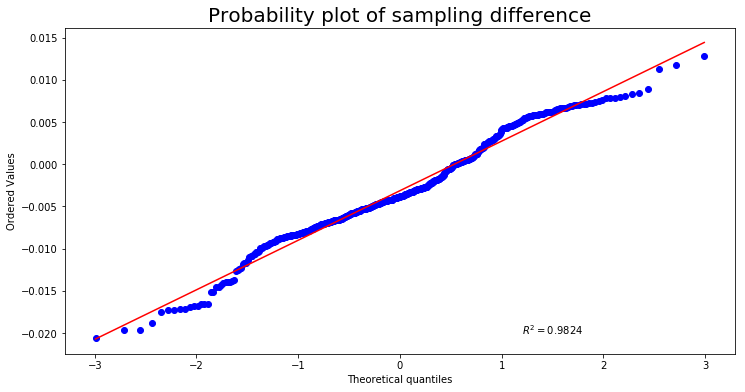

In [115]:
sampling_difference = df_treatment['Compliant Rate'].values - \
                    df_control['Compliant Rate'].values

# sampling_difference2 = df_treatment['Compliant Rate (Log)'].values - \
#                     df_control['Compliant Rate (Log)'].values

fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [116]:
stats.shapiro(sampling_difference) # data is non normal since p value < 0.05

(0.9818898439407349, 7.004032340773847e-06)

In [117]:
stats.normaltest(sampling_difference)

NormaltestResult(statistic=0.13535414697201242, pvalue=0.9345622197734095)

In [118]:
stats.ks_2samp(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

Ks_2sampResult(statistic=0.03600000000000003, pvalue=0.8969819972425297)

In [91]:
# transform data
df_treatment['Compliant Rate (Log)'] = np.sqrt(df_treatment['Compliant Rate'])
df_control['Compliant Rate (Log)'] = np.sqrt(df_control['Compliant Rate'])
df_AB['Compliant Rate (Log)'] = np.sqrt(df_AB['Compliant Rate'])

In [92]:
stats.ks_2samp(df_treatment['Compliant Rate (Log)'], df_control['Compliant Rate (Log)'])

Ks_2sampResult(statistic=0.1100000000000001, pvalue=0.004277444915243255)

HOMOGENEITY OF VARIANCES

In [119]:
stats.levene(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

LeveneResult(statistic=0.014140321276582749, pvalue=0.9053681471756329)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D199D467F0>,
      dtype=object)

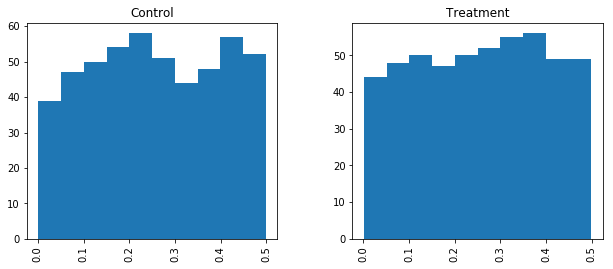

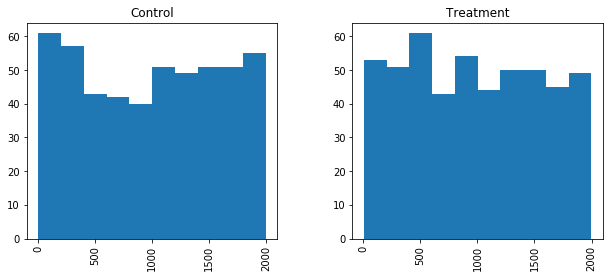

In [120]:
df_AB.hist(by='Group',column='Compliant Rate', figsize=[10, 4])
df_AB.hist(by='Group',column='Customer Calls', figsize=[10, 4])

In [121]:
scipy.stats.ttest_ind(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

Ttest_indResult(statistic=-0.3511547655823801, pvalue=0.7255463595369571)

In [122]:
stats.bartlett(df_treatment['Compliant Rate'],
               df_control['Compliant Rate'])

BartlettResult(statistic=0.006539613283687296, pvalue=0.9355470279233566)

In [123]:
rp.ttest(group1= df_treatment['Compliant Rate'], group1_name= "Treatment",
         group2= df_control['Compliant Rate'], group2_name= "Control")

(    Variable       N      Mean        SD        SE  95% Conf.  Interval
 0  Treatment   500.0  0.254600  0.141401  0.006324   0.242176  0.267025
 1    Control   500.0  0.257735  0.140889  0.006301   0.245356  0.270114
 2   combined  1000.0  0.256168  0.141083  0.004461   0.247413  0.264923,
                     Independent t-test   results
 0  Difference (Treatment - Control) =    -0.0031
 1                Degrees of freedom =   998.0000
 2                                 t =    -0.3512
 3             Two side test p value =     0.7255
 4            Difference < 0 p value =     0.3628
 5            Difference > 0 p value =     0.6372
 6                         Cohen's d =    -0.0222
 7                         Hedge's g =    -0.0222
 8                    Glass's delta1 =    -0.0222
 9                  Point-Biserial r =    -0.0111)

Control and treatment groups have similar mean and stdev, p value of t-test is 0.7255 > 0.5, indicating the mean of two groups have no statistical significant difference.